# Time Series Forecasting Models: ETS

In this post, you will learn the steps to create two different models for time series forecasting. Using these models, you will be able to make predictions for the future values of things like hotel bookings, product sales, and any other times series, using only historical data of that value. Let's get started!

## ETS Models

ETS stands for error, trend, and seasonality. ETS models break out the trend and seasonality components of the data. The trend and seasonality patterns are then projected into the future to create the forecasts. There are four major steps to creating a good ETS model:
1. Create time series decomposition plot
2. Determine error, trend, and seasonality
3. Build and validate the ETS model
4. Forecast

Let's walk through the details of each step.

### Create time series decomposition plot

A time series decomposition plot allows you to visualize the trend, seasonality, and error of your original data. This visualization will aid in determing if you should use an additive or a multiplicative model, and if you have selected the right number of periods to capture the seasonality appropriately.

We'll demonstrate the first step using champagne-sales.csv. This dataset is available through the Udacity Time Series Forecasting course ([its free](https://www.udacity.com/course/time-series-forecasting--ud980)).

The Udacity class uses Alteryx for data analysis. We'll be doing everything in Python, so they way we build the models will be slightly different from the Udacity course.

The statsmodels library has time series analysis tools that can create time series decomposition plots. When using the statsmodels decompose function, we need to specify whether to use an additive or a multiplicative model. An additive model means the errot, trend, and seasonality components are added together, while they are multiplied together for a multiplicative model.

Additive: 

$ y = E_t + T_t + S_t $

Multiplicative:

$ y = E_t * T_t * S_t $

We will compare the decomposition plots from the two model types in order to compete step two of the process.

In [1]:
# load modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import holtwinters
from matplotlib import gridspec

In [2]:
# load and setup data
data = pd.read_csv('champagne-sales.csv')
# there are 96 observations representing 8 years of monthly data
# we are chooseing an arbitrary start date
data.index = pd.date_range(start='2010-01-01', periods=len(data), freq='m')
# drop the month column since the we have replaced it with the index
data.drop('Month',axis=1,inplace=True)

In [3]:
# create additive plot and multiplicative plot side by side
additive = sm.tsa.seasonal_decompose(data['Champagne Sales'], model='add', freq=12)
multiplicative = sm.tsa.seasonal_decompose(data['Champagne Sales'], model='mult', freq=12)

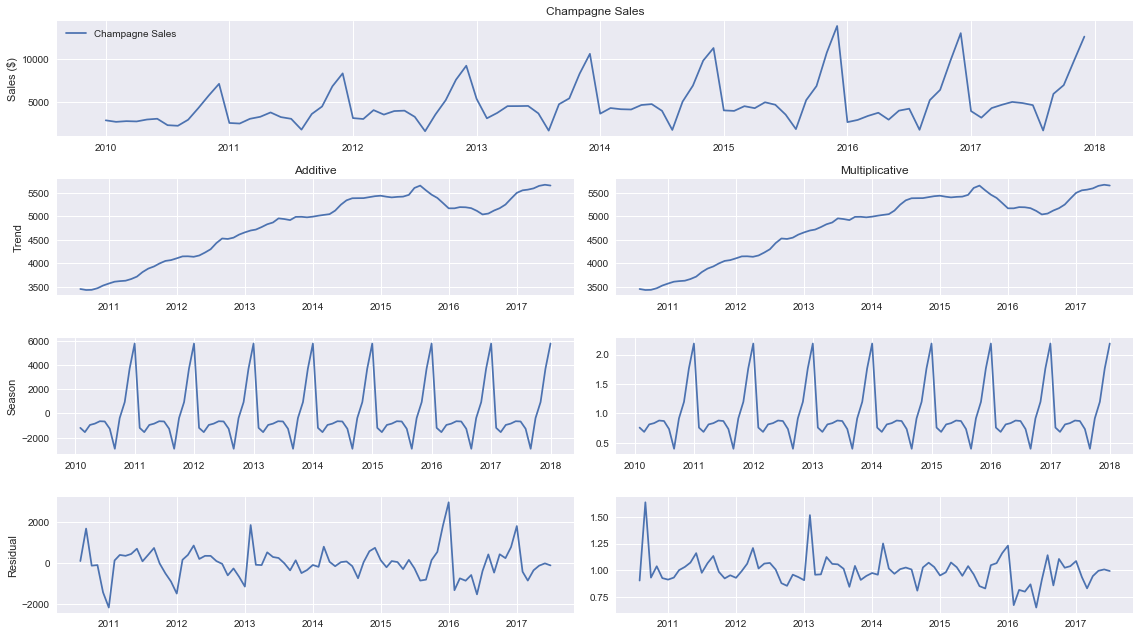

In [4]:
fig = plt.figure(figsize=(16,9))
spec = gridspec.GridSpec(ncols=2, nrows=4)
ax1 = fig.add_subplot(spec[0, :])
ax1.set_ylabel('Sales ($)')
ax1.set_title('Champagne Sales')
data.plot(kind='line', ax=ax1)
ax2 = fig.add_subplot(spec[1,0])
ax2.plot(additive.trend)
ax2.set_ylabel('Trend')
ax2.set_title('Additive')
ax3 = fig.add_subplot(spec[2,0])
ax3.plot(additive.seasonal)
ax3.set_ylabel('Season')
ax4 = fig.add_subplot(spec[3,0])
ax4.plot(additive.resid)
ax4.set_ylabel('Residual')
ax5 = fig.add_subplot(spec[1,1])
ax5.plot(multiplicative.trend)
ax5.set_title('Multiplicative')
ax6 = fig.add_subplot(spec[2,1])
ax6.plot(multiplicative.seasonal)
ax7 = fig.add_subplot(spec[3,1])
ax7.plot(multiplicative.resid)
plt.tight_layout()
plt.show();

### Determine error, trend and seasonality

Comparing these decompositions plots, we notice that there is one big difference between them. The residual (error) plot at the bottom is much larger for the additive model. This means that the additive model is not able to adequately capture the time series characteristics. The multiplicative model is the better choice because it captures the trend and seasonality of the data with a low amount of residual error.

In some instances, you will need to choose whether the error, trend, and seasonality should be additive, multiplicative (or even not included) individually. In that case, here's how you do it:

If the trend plot is linear, apply it additively. If the trend line grows exponentially, apply it multiplicatively. If there is no clear trend, it can be removed from the model.

If the seasonal plot peaks and valleys are constant over time, apply the seasonality component additively. If the seasonality component peaks and valleys grow or shrink over time, apply this component multiplicatively. If there is no seasonality component, it is not applied.

We view the error term in a similar fashion as the seasonality term. If the variance of the peaks and valleys is steady over time, apply it additively. If the variance of the peaks and valleys grows or shrinks over time, apply it multiplicatively.

Following these instructions, we could implement a more specific model in which we include no trend component (because the trend flattens at the end), an additive seasonal component (because the magnitude of the peaks and valleys are consistent), and a multiplicative residual term (because the peaks get smaller over time).

Now that we have decided to use a multiplicative model, we can move on to step three.

### Build and validate the model

Now that we have determined the type of model to build, we can use statsmodels to do so. After we construct the model, we will compute performance metrics to describe the performance and allow us to compare the model to others we could build for this dataset.


In [5]:
# split the data into train and test to evaluate performance
train, test = data.iloc[:90,0], data.iloc[90:,0]
model = holtwinters.ExponentialSmoothing(train, trend=None, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

To validate the model we need to compare the performance of the test set predictions to the test values. There are several performance metrics we use to compare models

**Mean Error (ME)** - the average difference between the actual and forecasted values.

**Mean Percentage Error (MPE)** - average percent difference between the actual and forecasted values.

ME and MPE indicate if the forecasts are biased positively or negatively.

**Root Mean Squared Error (RMSE)** - indicates the average distance between the forecast values and the actual values. Squaring the difference gives more weight to points where there is a large difference between the forecasted and actual values. Taking the square root puts the RMSE on the same scale as the original data.

**Mean Absolute Error (MAE)** - similar to RMSE without squaring the differences. It is less sensitive to infrequent large errors in forecasting.

**Mean Absolute Percentage Error (MAPE)** - similar to MAE, but expressed as a percentage difference. Good for reporting because it removes the scale. Telling someone the predictions are off by 5% or 30% is easy to interpret.

**Mean Absolute Scaled Error (MASE)** - the MAE divied by the mean absolute value of the first difference of the series. It measures relative reduction in error of the model compared to a naive model.

**Akaike Information Criterion (AIC)** - a score which balances the complexity of the model with its goodness of fit. It can be used to measure the relative quality of statistical model.

In [6]:
# calculate metrics

def equal_arrays(x1, x2):
    if len(x1) != len(x2):
        raise ValueError("The inpute arrays are not the same length")

def me(y_pred, y_test):
    equal_arrays(y_pred, y_test)
    n = len(y_test)
    return np.sum(y_pred - y_test)/n

def mpe(y_pred, y_test):
    equal_arrays(y_pred, y_test)
    n = len(y_test)
    return (np.sum((y_pred / y_test)-1)/n) * 100

def rmse(y_pred, y_test):
    equal_arrays(y_pred, y_test)
    n = len(y_test)
    return (np.sum((y_pred-y_test)**2)/n)**0.5

def mae(y_pred, y_test):
    equal_arrays(y_pred, y_test)
    n = len(y_test)
    return np.sum(abs(y_pred - y_test))/n

def mape(y_pred, y_test):
    equal_arrays(y_pred, y_test)
    n = len(y_test)
    return (np.sum(abs((y_pred/y_test)-1))/n) * 100

def mase(y_pred, y_test):
    equal_arrays(y_pred, y_test)
    n = len(y_test)
    performance = mae(y_pred, y_test)
    mean_diff = np.mean(abs(y_test - y_test.shift(1)))
    return performance / mean_diff      

In [7]:
results = {'ME':me(pred, test), 'MPE':mpe(pred, test), 'RMSE':rmse(pred, test),
          'MAE':mae(pred, test), 'MAE':mae(pred, test), 'MAPE':mape(pred, test),
          'MASE':mase(pred, test), 'AIC':model.aic}

In [8]:
result_frame = pd.DataFrame(results ,index=['ETS(M,N,M)'])
result_frame

,AIC,MAE,MAPE,MASE,ME,MPE,RMSE
"ETS(M,N,M)",1164.259609,402.527575,10.242953,0.143914,-104.128228,0.990379,466.751387


Normally, these performance metrics would be used to compare different models before selecting the best to use for forecasting. If we were to report the performance of the model to a non-technical audience the MAPE is easily accessible, as we can say the model has a 10% prediction error on average.

### Forecast

Now we can retrain our model on the full dataset and forecast future values of champagne sales.

In [9]:
# predictions with holdout sample added back to the model
full_model = holtwinters.ExponentialSmoothing(data.iloc[:,0], trend=None, seasonal='mul', seasonal_periods=12).fit()
preds = full_model.forecast(6) # make 6 months of predictions

In [10]:
# now calculate confidence intervals for new test x-series
mean_x = np.mean(data).values # mean of x
n = len(data) # number of samples in origional fit
t = 1.96 # t-value for 95% CI
y_err = (full_model.predict(start=data.index[0], end=data.index[-1]) - data.iloc[:,0]) # residuals
s_err = np.sum(np.power(y_err,2)) # sum of the squares of the residuals
confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((preds-mean_x),2)/
        ((np.sum(np.power(data.values,2)))-n*(np.power(mean_x,2))))))
lower = preds - abs(confs)
upper = preds + abs(confs)

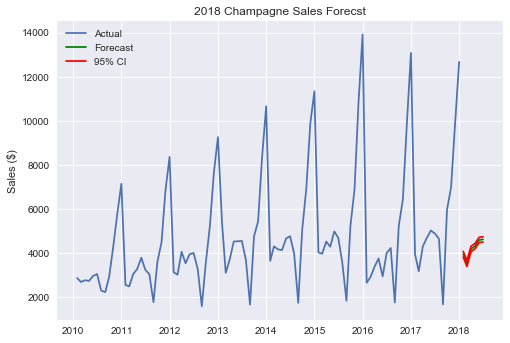

In [11]:
# plot predictions with 95% CI
plt.plot(data)
plt.plot(preds, 'g')
plt.plot(preds.index, lower, color='r')
plt.plot(preds.index, upper, color='r')
plt.legend(['Actual','Forecast','95% CI'])
plt.ylabel('Sales ($)')
plt.title('2018 Champagne Sales Forecst')
plt.show()

In this post, you have learned how to create and evaluate an ETS time series model to forecast the future! You should now be able to apply these concepts to new datasets. Try creating an additive model with this same dataset. How do your results compare?

In our next post, we will walk through creating an ARIMA model with this same dataset and compare their performances.